Digite o nó que enviará a sonda em G: 
Matriz de Sondas =  [[1, 5, 3], [2, 6, 4], [7]]
  Topology         Where MPolka MPINT INT Clássico
0     Isis     DataPlane    170   129          340
1     Isis  ControlPlane     51    44          170
  Topology         Where MPolka MPINT INT Clássico
0     Isis     DataPlane    170   129          340
1     Isis  ControlPlane     51    44          170
2    Isis2     DataPlane    170   129          340
3    Isis2  ControlPlane     51    44          170
[['1', '2'], ['1', '4'], ['2', '1'], ['2', '3'], ['2', '4'], ['3', '2'], ['3', '5'], ['4', '1'], ['4', '2'], ['4', '6'], ['5', '3'], ['5', '6'], ['5', '9'], ['6', '4'], ['6', '5'], ['6', '8'], ['7', '8'], ['7', '11'], ['8', '6'], ['8', '7'], ['8', '9'], ['9', '5'], ['9', '8'], ['9', '10'], ['10', '9'], ['10', '11'], ['11', '7'], ['11', '10']]


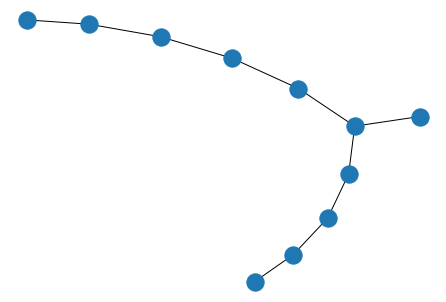

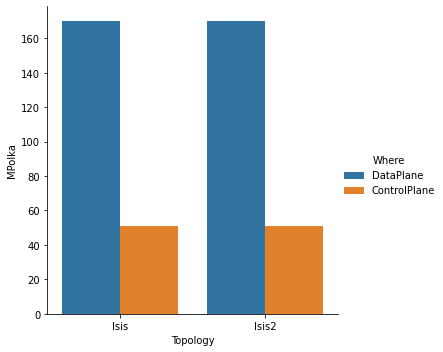

In [70]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

GIsis = nx.from_edgelist([[1,5],[5,3],[1,2],[2,6],[6,4],[6,7]])
sonda = []
sondaTemp = []

def EdgeListToMST(path):
    edgeList = readTopology(path)
    print(edgeList)
    G = nx.from_edgelist(edgeList)
    T = nx.minimum_spanning_tree(G,algorithm='prim')
    return T

def toDataframe(df,topology,sonda):
    #Overhead por abordagem
    overheadDP_mPolka = 0
    overheadDP_mPINT = 0
    overheadDP_INTClassico = 0
    overheadCP_mPolka = 0
    overheadCP_mPINT = 0
    overheadCP_INTClassico = 0

    for i in range(len(sonda)):
        overheadDP_mPolka += mPolkaDP_fixoPSonda + mPolkaDP_fixoPNo*len(sonda[i])
        overheadDP_mPINT += mPINTDP_fixoPSonda + mPINTDP_fixoPNo*len(sonda[i])
        overheadDP_INTClassico += INTClassicoDP_fixoPSonda + INTClassicoDP_fixoPNo*len(sonda[i])

        overheadCP_mPolka += mPolkaCP_fixoPSonda + mPolkaCP_fixoPNo*len(sonda[i])
        overheadCP_mPINT += mPINTCP_fixoPSonda + mPINTCP_fixoPNo*len(sonda[i])
        overheadCP_INTClassico += INTClassicoCP_fixoPSonda + INTClassicoCP_fixoPNo*len(sonda[i])

    #print('Overhead DataPlane MPolka = ',overheadDP_mPolka)
    #print('Overhead DataPlane MPINT = ',overheadDP_mPINT)
    #print('Overhead DataPlane INT Clássico = ',overheadDP_INTClassico)
    #print('Overhead ControlPlane MPolka = ',overheadCP_mPolka)
    #print('Overhead ControlPlane MPINT = ',overheadCP_mPINT)
    #print('Overhead ControlPlane INT Clássico = ',overheadCP_INTClassico)

    matrixOverhead = {}
    matrixOverhead['Topology'] = [topology,topology]
    matrixOverhead['Where'] = ['DataPlane','ControlPlane']
    matrixOverhead['MPolka'] = [overheadDP_mPolka,overheadCP_mPolka]
    matrixOverhead['MPINT'] = [overheadDP_mPINT,overheadCP_mPINT]
    matrixOverhead['INT Clássico'] = [overheadDP_INTClassico,overheadCP_INTClassico]
    df2 = pd.DataFrame(data=matrixOverhead)
    result = pd.concat([df,df2],ignore_index=True)
    return result

def readTopology(path):
    edgeList = []

    with open(path,'r') as arq:
        lines = arq.readlines()
    
    for i in range(len(lines)):
        line = lines[i].split(' ')
        line.pop()
        edgeList.append(line)
        #print(line)
    
    return edgeList

def dfs(G,v,visited): #Retorna a matriz de sondas do MPolka
  sondaTemp.append(v)
  visited[v] = True
  for w in G.neighbors(v):
    if len(list(G.neighbors(v))) == 1: #DEADEND
        #print(sondaTemp)
        sonda.append(sondaTemp.copy())
        sondaTemp.clear()
    if not visited[w]:
        dfs(G,w,visited)
  return sonda

print('Digite o nó que enviará a sonda em G: ')
node = int(input())

print('Matriz de Sondas = ',sondaIsis)

mPolkaDP_fixoPSonda = 10
mPolkaDP_fixoPNo = 20
mPolkaCP_fixoPSonda = 3
mPolkaCP_fixoPNo = 6

mPINTDP_fixoPSonda = 8
mPINTDP_fixoPNo = 15
mPINTCP_fixoPSonda = 3
mPINTCP_fixoPNo = 5

INTClassicoDP_fixoPSonda = 20
INTClassicoDP_fixoPNo = 40
INTClassicoCP_fixoPSonda = 10
INTClassicoCP_fixoPNo = 20

df = pd.DataFrame(columns=['Topology','Where','MPolka','MPINT','INT Clássico']) #Empty Row Dataframe

sondaIsis = dfs(GIsis,node,[False] * (GIsis.number_of_nodes() + 1))
df = toDataframe(df,'Isis',sondaIsis)
print(df)

df = toDataframe(df,'Isis2',sondaIsis)
print(df)

GAbilene = EdgeListToMST('topologydata/abilene/TOPOLOGY')
nx.draw(GAbilene)
#sondaAbilene = dfs(GAbilene,node,[False] * (GAbilene.number_of_nodes() + 1))
#print('Matriz de Sondas Abilene = ',sondaAbilene)
#df = toDataframe(df,'Abilene',sondaAbilene)
#print(df)

#sns.displot(df, x="MPolka",hue="Where",element="step");
sns.catplot(x="Topology", y="MPolka", hue="Where",kind="bar", data=df, errorbar = None);